In [1]:
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def select_func(x):
    if isinstance(x, list):
        return x[0]
    elif isinstance(x, dict):
        return x.get('correctness', 'failed')
    else:
        return x

#### Extract model performance

In [3]:
model_performance = []
for file in os.listdir('Results'):
    if file.endswith('.json'):
        model = file.split('_')[0]
        problem = file.split('_')
        problem = "_".join(problem[1:])
        problem = problem.split('.')[0]
        with open('Results/' + file) as f:
            correct = []
            for line in f.readlines()[-1:]:
                data = json.loads(line)
                correct.extend([select_func(x.get('correctness', 'failed')) for x in data])
            performance = {
                'model': model,
                'problem': problem,
                'correct': correct
            }
            model_performance.append(performance)

#### Calculate model accuracy

In [4]:
def calculate_accuracy(expr_result):
    model_name = expr_result['model']
    problem_name = expr_result['problem']
    correct = expr_result['correct']
    assert len(correct) == 100, f'Incorrect number of results for {model_name} on {problem_name} with {len(correct)} results'
    level_correctness = [correct[i:i+10] for i in range(0, len(correct), 10)]
    filter_failed = lambda x: [y for y in x if y != 'failed']
    level_correctness = [filter_failed(x) for x in level_correctness]
    
    failed_expr = [10 - len(x) for x in level_correctness]
    failed_num = sum(failed_expr)
    failed_expr = [x / 10 for x in failed_expr]
    if failed_num > 0:
        print(f'{model_name} on {problem_name} has {failed_num} failed results')
    level_accuracy = []
    for x in level_correctness:
        if len(x) == 0:
            level_accuracy.append(0)
        else:
            level_accuracy.append(sum(x) / 10)
    return {
        'model': model_name,
        'problem': problem_name,
        'accuracy': level_accuracy,
        'failed': failed_expr
    }

#### Export to a csv file

In [5]:
result_df = []
for expr_result in model_performance:
    result = calculate_accuracy(expr_result)
    expr_df = pd.DataFrame(columns=['model', 'problem', 'level', 'Average accuracy', 'Failed'])
    model_name = result['model']
    problem_name = result['problem']
    accuracy = result['accuracy']
    failed = result['failed']

    expr_df['model'] = [model_name] * 10
    expr_df['problem'] = [problem_name] * 10
    expr_df['level'] = [f'Lvl {i+1}' for i in range(10)]
    expr_df['Average accuracy'] = accuracy
    expr_df['Failed'] = failed
    result_df.append(expr_df)

result_df = pd.concat(result_df)

claude-instant-1.2 on sppResults has 4 failed results
mistral on mspResults has 80 failed results
gpt-4-1106-preview on tspResults has 1 failed results
claude-2 on mspResults has 4 failed results
claude-instant-1.2 on mspResults has 5 failed results
phi on mspResults has 99 failed results
gpt-4-1106-preview on kspResults has 1 failed results
claude-2 on tspResults has 11 failed results
gpt-4-1106-preview on mspResults has 10 failed results
claude-instant-1.2 on gcpResults has 1 failed results
gpt-3.5-turbo on tspResults has 1 failed results
gpt-4-1106-preview on sppResults has 2 failed results
claude-2 on gcpResults has 1 failed results
claude-instant-1.2 on tspResults has 3 failed results


#### Basic setup

In [6]:
problem_map = {
    'sppResults': 1, 'mfpResults': 1, 'bspResults': 1,
    'tsp_d_Results': 2, 'gcp_d_Results': 2, 'kspResults': 2,
    'tspResults': 3, 'gcpResults': 3, 'mspResults': 3,
}

result_df['problem_order'] = result_df['problem'].map(problem_map)

In [7]:
result_df.model.unique()

array(['claude-instant-1.2', 'gpt-3.5-turbo', 'vicuna', 'mistral',
       'gpt-4-1106-preview', 'claude-2', 'mpt', 'yi', 'phi'], dtype=object)

In [8]:
close_models = ['gpt-4-1106-preview', 'gpt-3.5-turbo', 'claude-2', 'claude-instant-1.2']

open_model_df = result_df[~result_df['model'].isin(close_models)]
close_model_df = result_df[result_df['model'].isin(close_models)]

problem_set = result_df['problem'].unique()

In [9]:
result_df.problem.unique()

array(['sppResults', 'mspResults', 'tspResults', 'mfpResults',
       'tsp_d_Results', 'bspResults', 'gcp_d_Results', 'gcpResults',
       'kspResults'], dtype=object)

In [10]:
import numpy as np
def plot_figure(y_name, result_df, prefix=''):
    for x in result_df.problem_order.unique():
        data = result_df[result_df['problem_order'] == x]
        plt.style.use('ggplot')
        num_models = len(data.model.unique())
        num_problems = len(data.problem.unique())
        # Plot for all models with side by side comparison
        fig, axes = plt.subplots(num_problems, num_models, figsize=(5 * num_models, 3 * num_problems))
        for i, problem in enumerate(data.problem.unique()):
            for j, model in enumerate(data.model.unique()):
                ax = axes[i, j]
                selected_data = data[(data['model'] == model) & (data['problem'] == problem)]
                sns.lineplot(data=selected_data, x='level', y=y_name, ax=ax)
                ax.set_ylabel(f'{problem}')
                ax.set_xlabel(f'{model}')
                ax.set_ylim(0, 1.1)
        hard_mapper = {
            1: 'p',
            2: 'np-cmp',
            3: 'np-hard'
        }
        fig.suptitle(f'{y_name} for different {prefix} models on {hard_mapper[x]} problems', fontsize=16, y=1.01)
        fig.text(0.5, -0.02, 'Level', ha='center', fontsize=14)
        fig.text(-0.02, 0.5, y_name, va='center', rotation='vertical', fontsize=14)
        fig.tight_layout()
        fig.savefig(f'figures/{prefix}_model_{y_name}_{hard_mapper[x]}.png')

##### Open models

In [11]:
import os

if not os.path.exists('figures'):
    os.makedirs('figures')

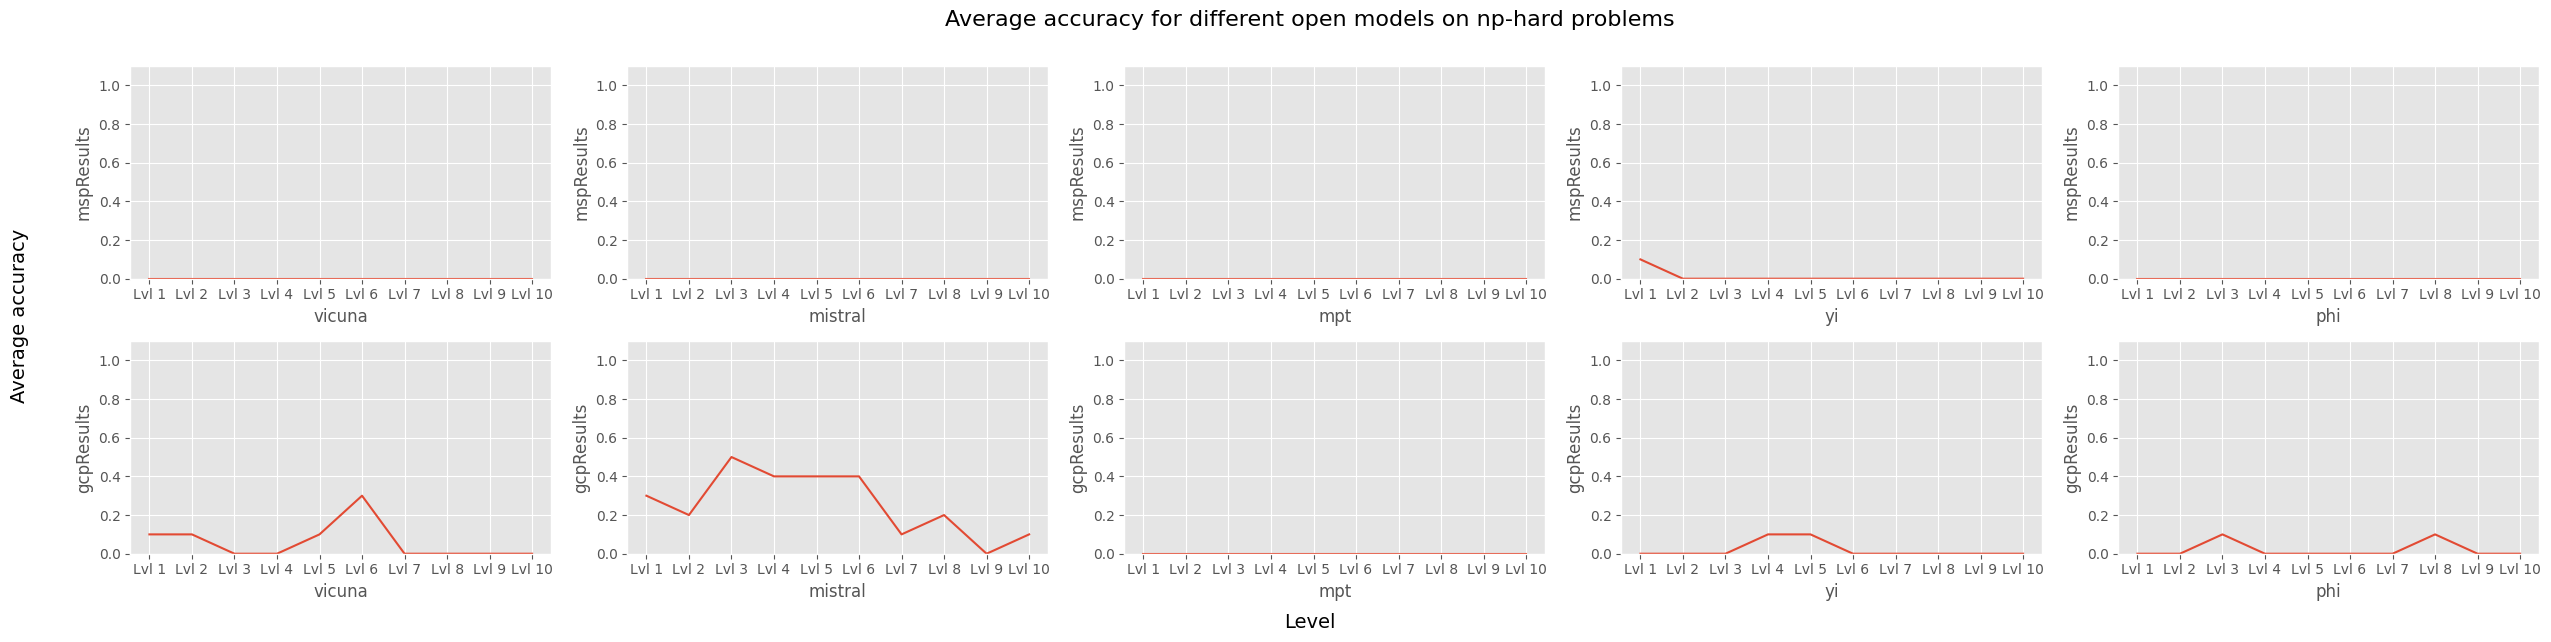

In [12]:
plot_figure('Average accuracy', open_model_df, prefix='open')

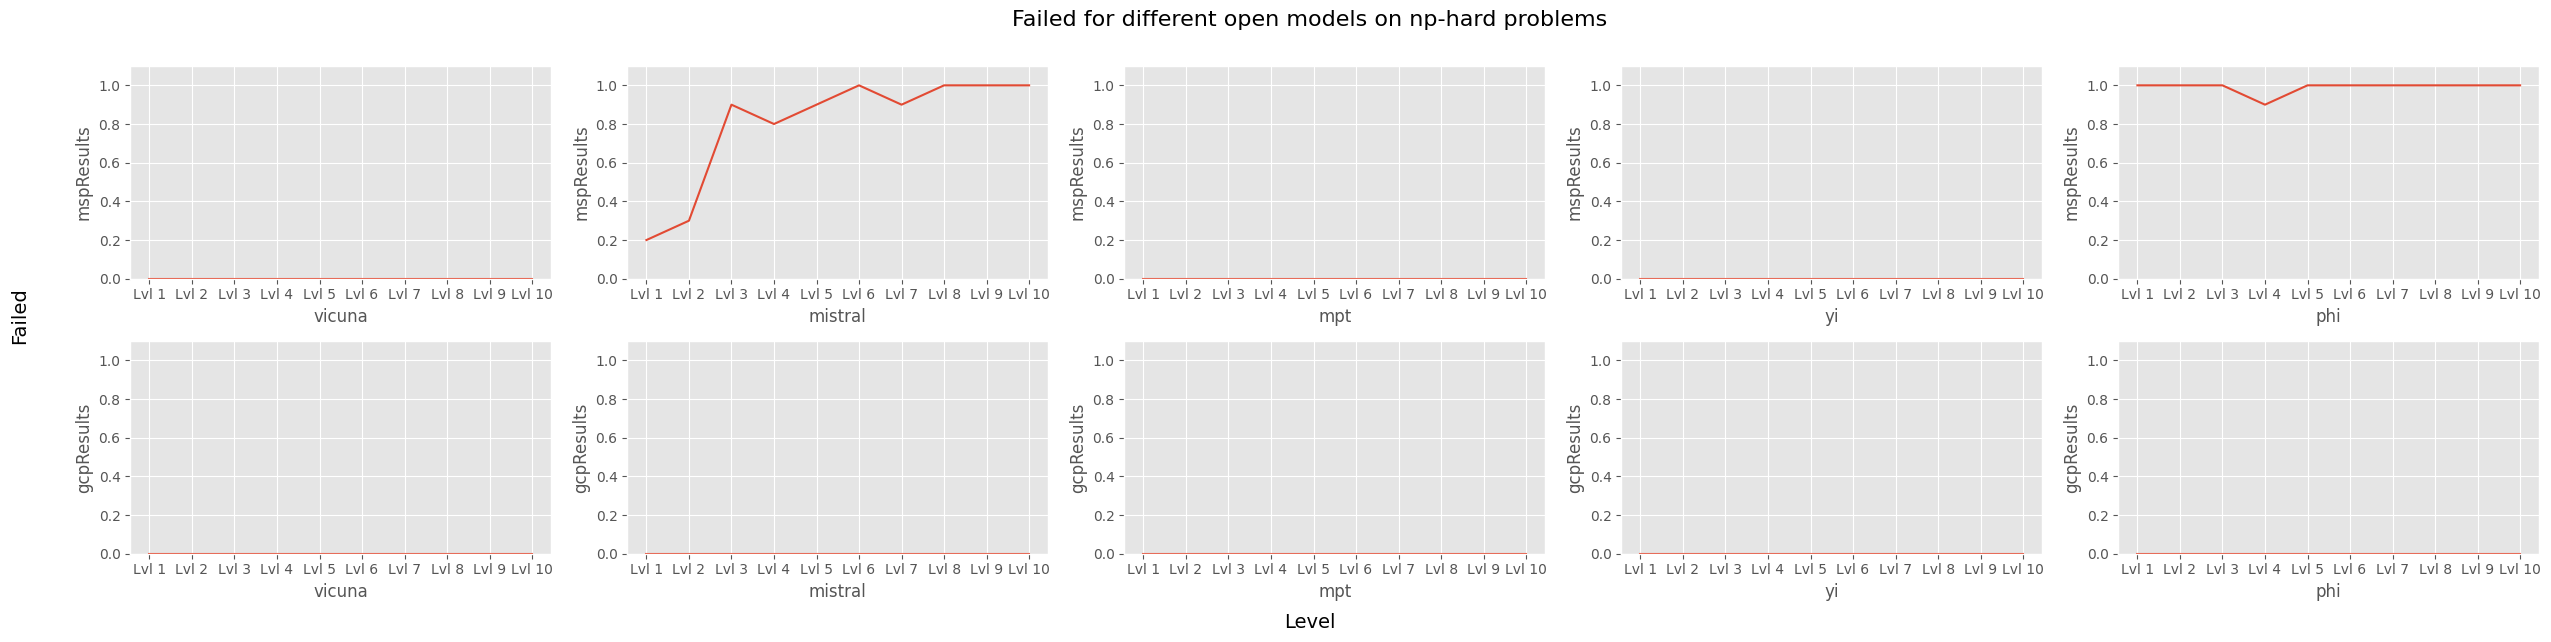

In [13]:
plot_figure('Failed', open_model_df, prefix='open')

##### Close models

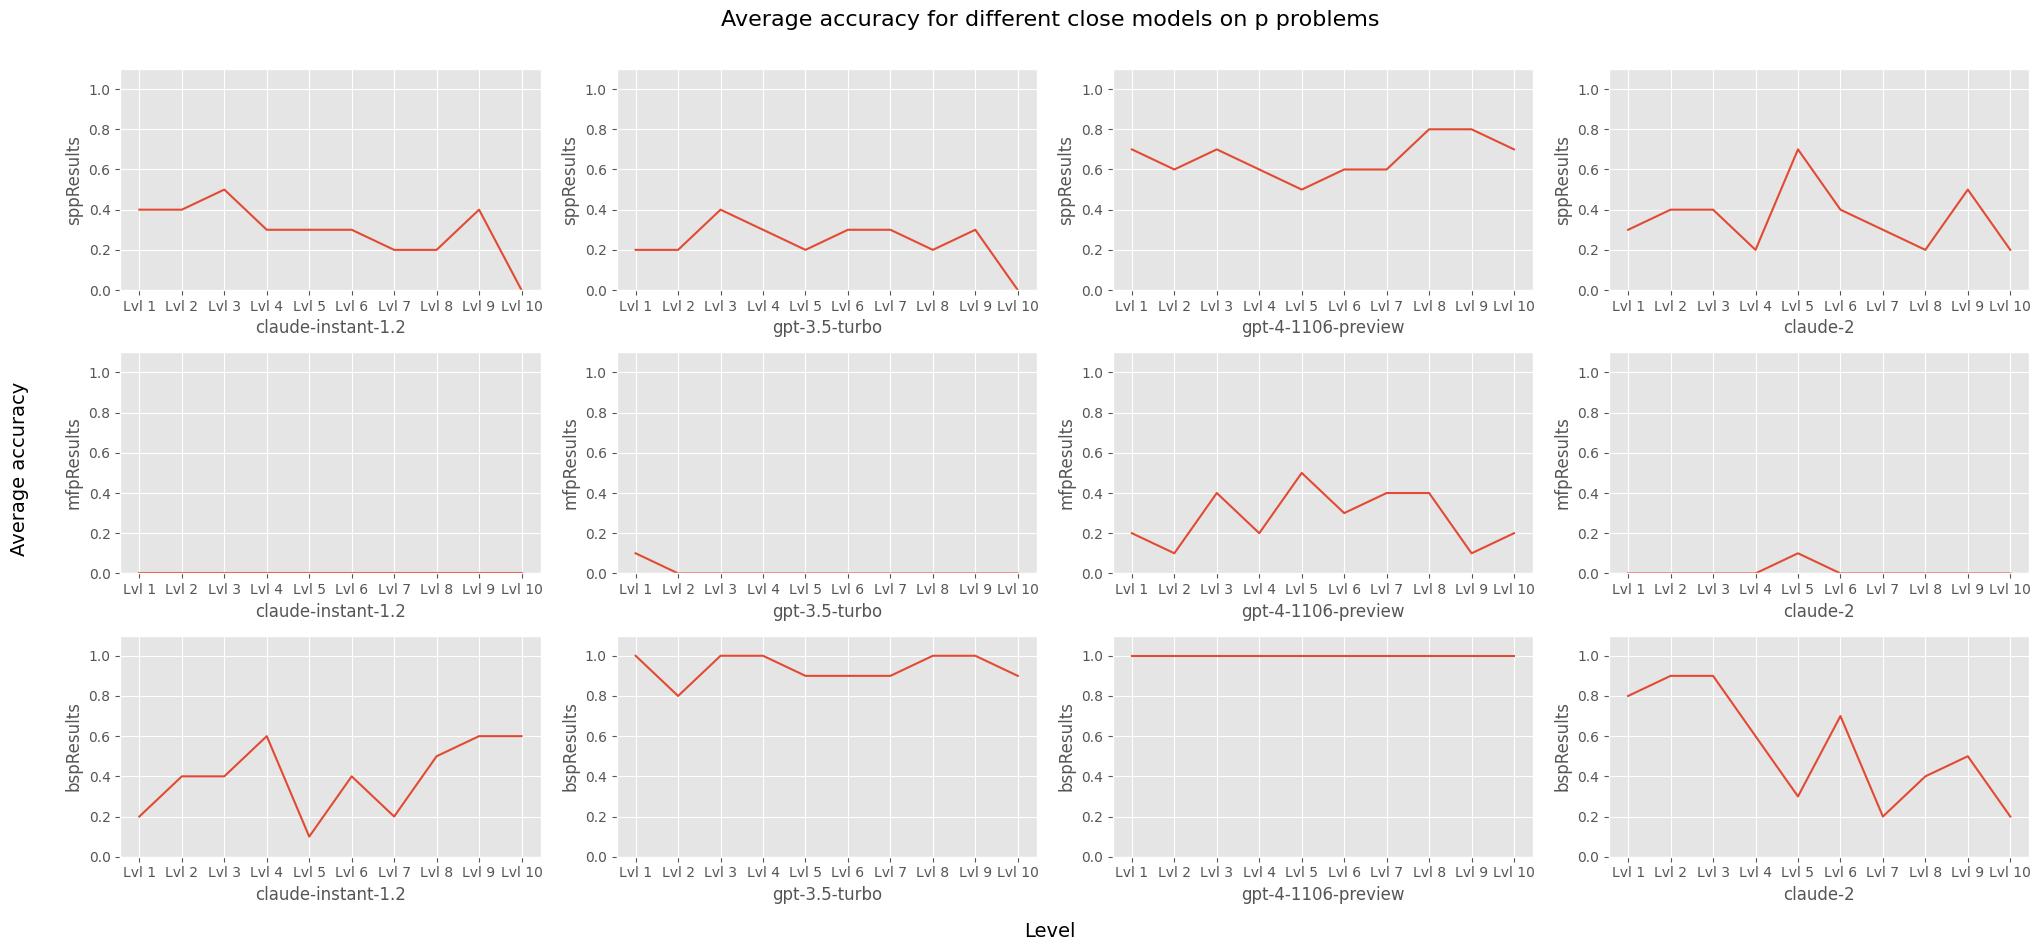

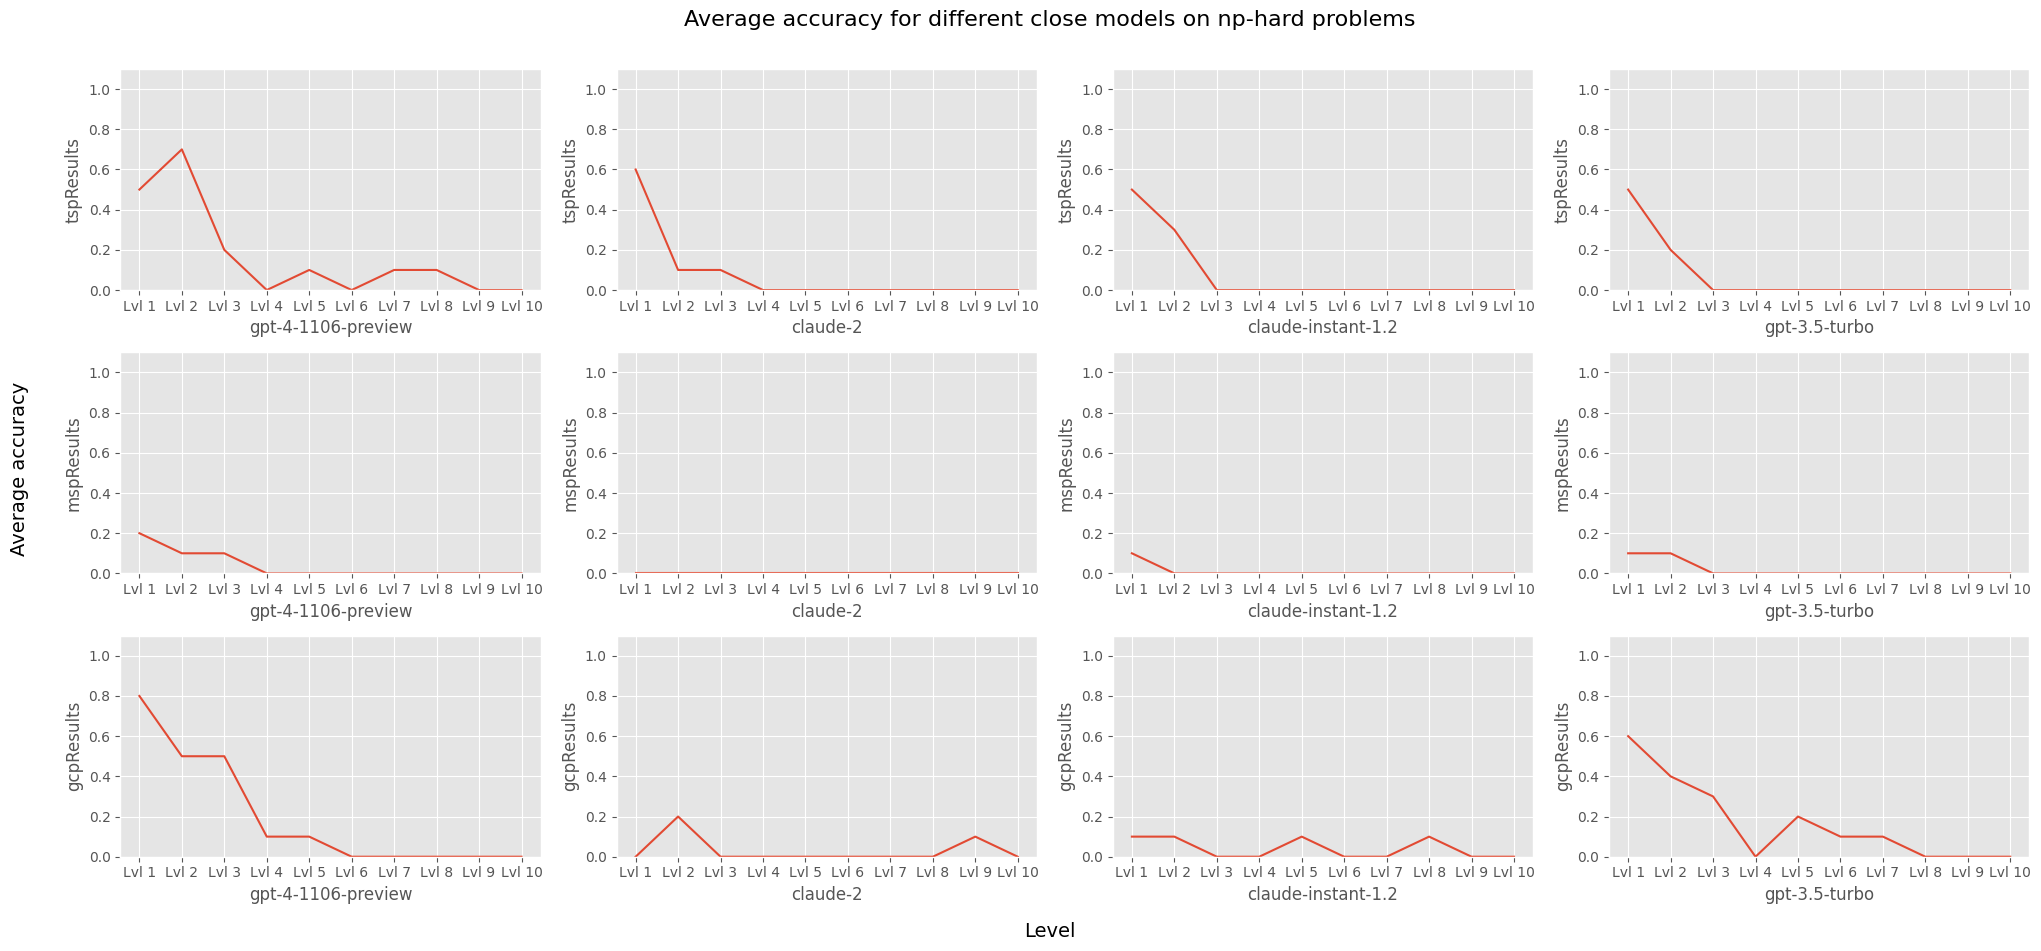

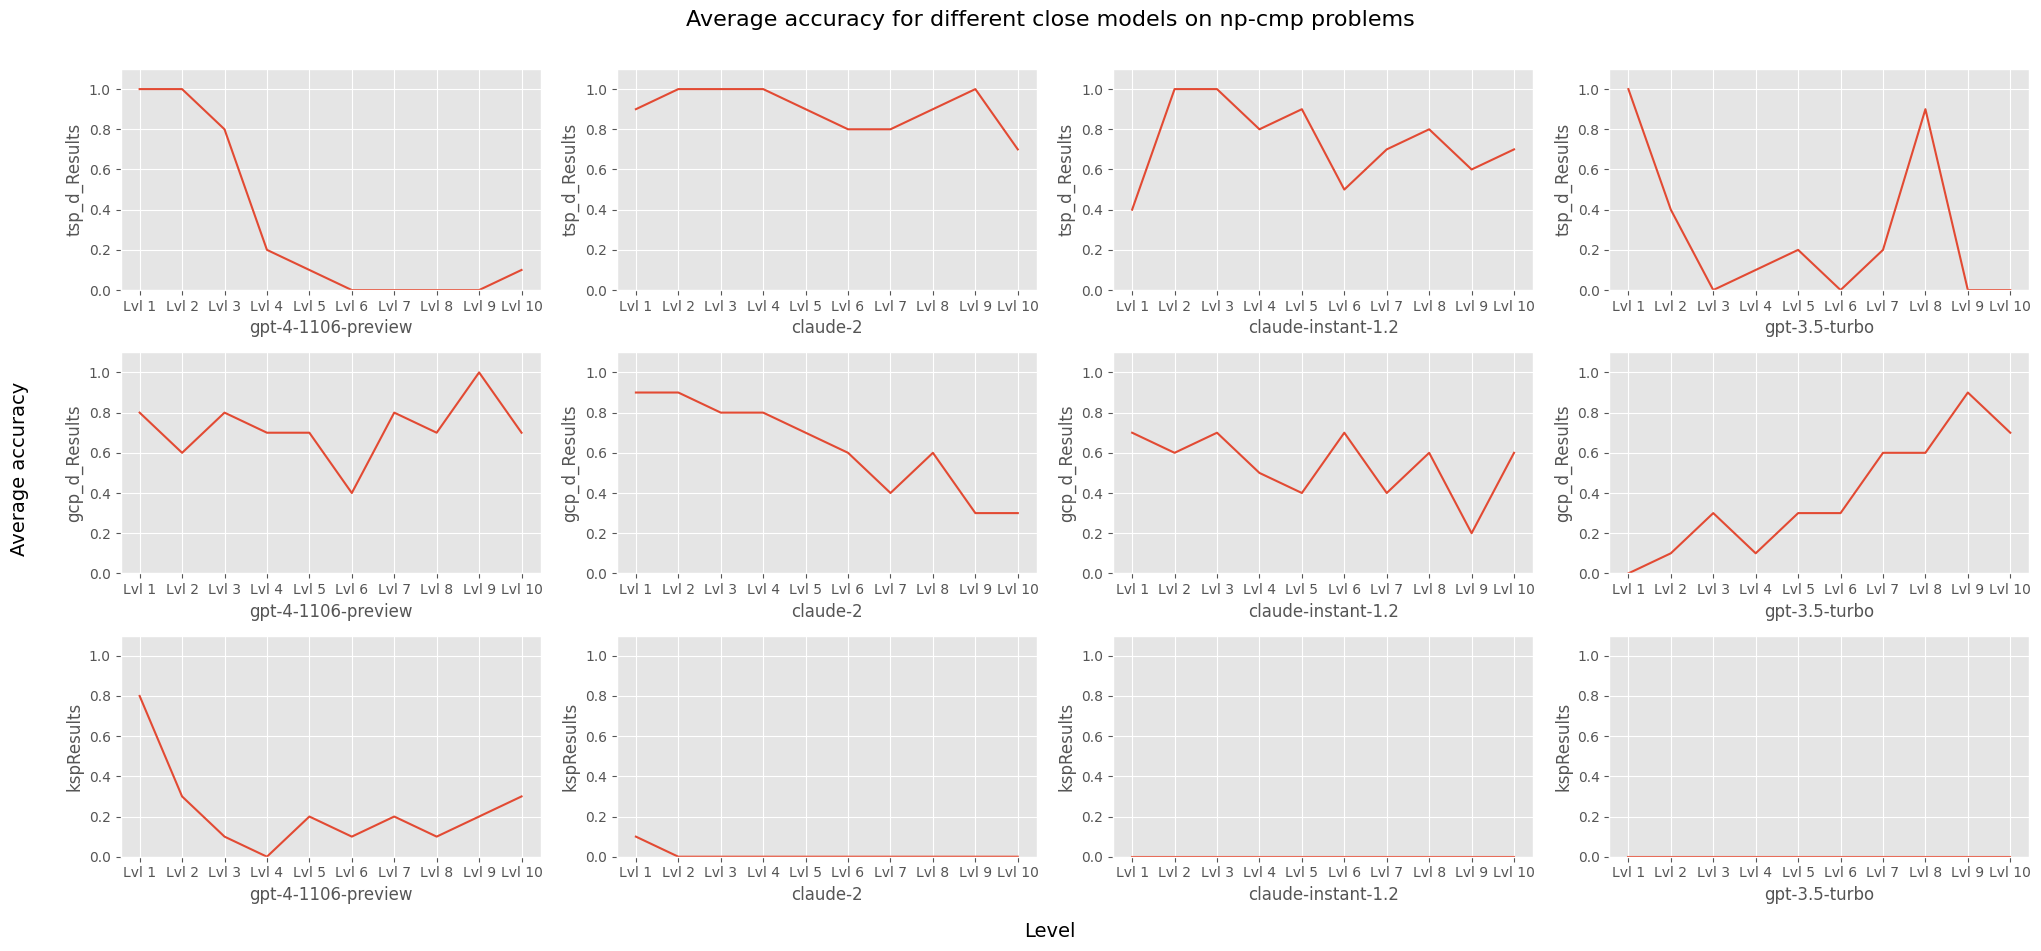

In [14]:
plot_figure('Average accuracy', close_model_df, prefix='close')

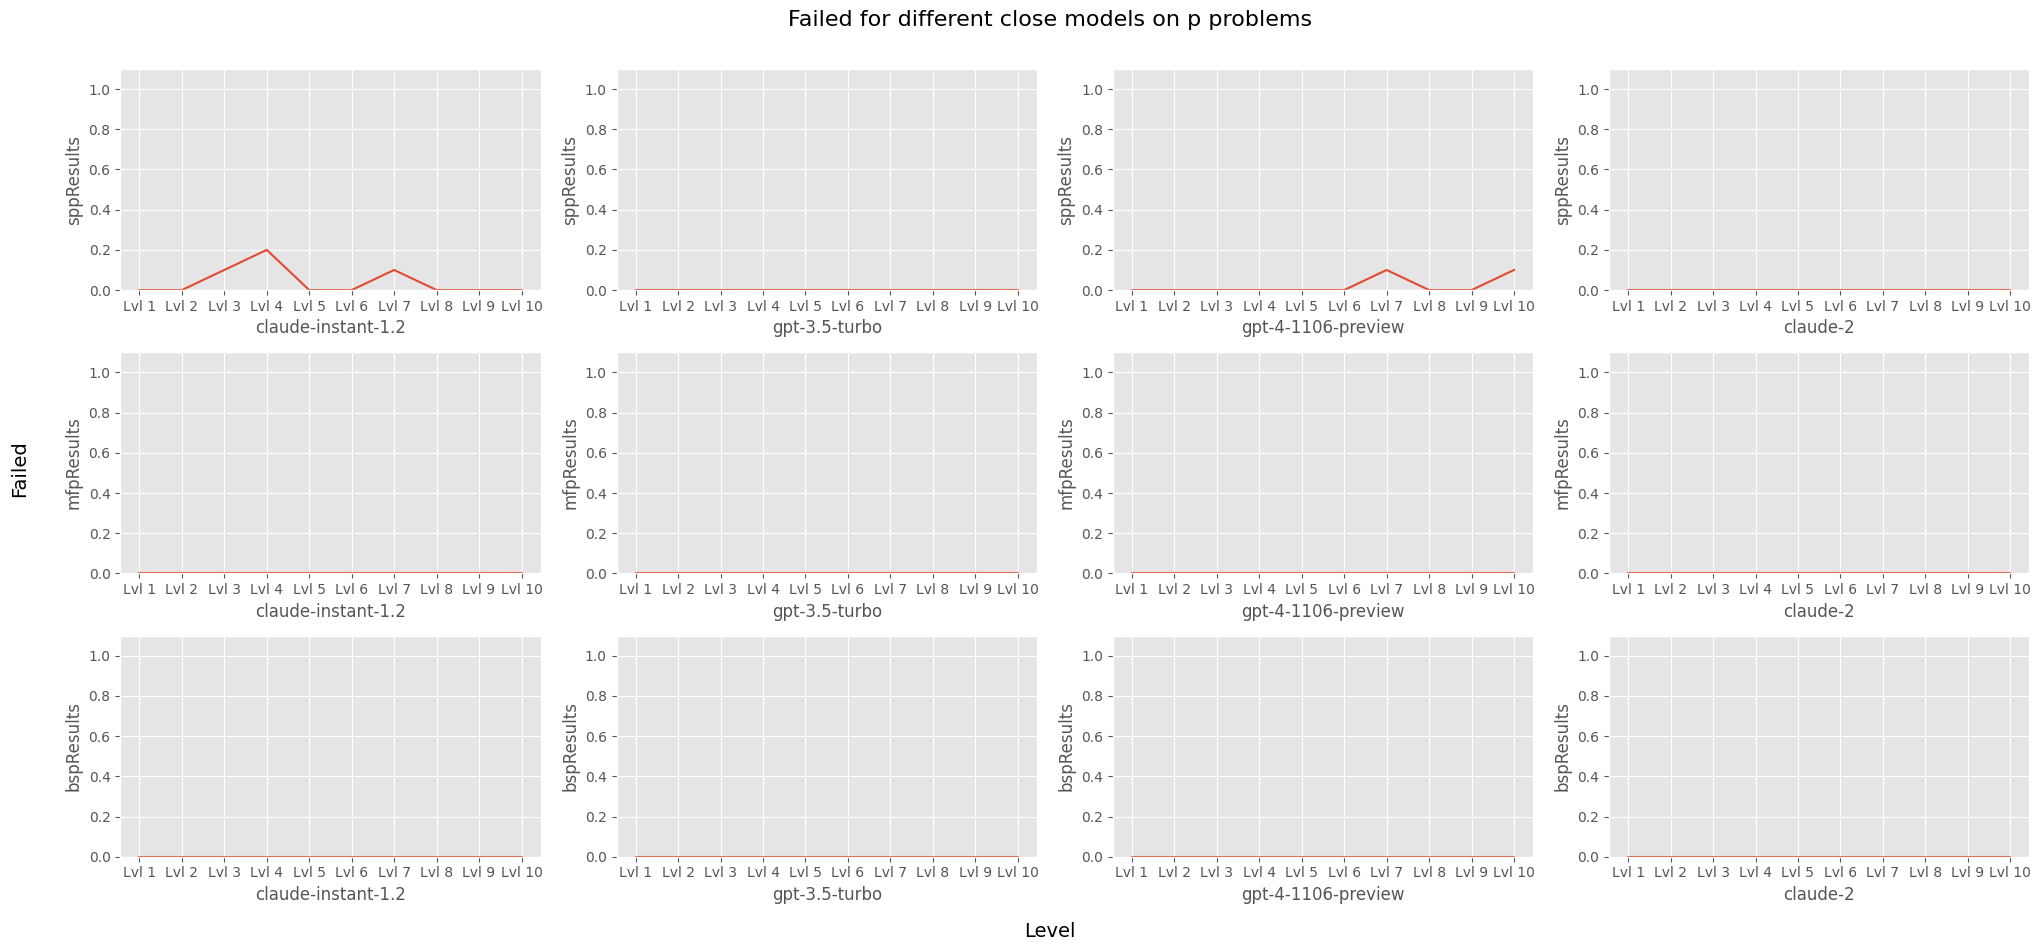

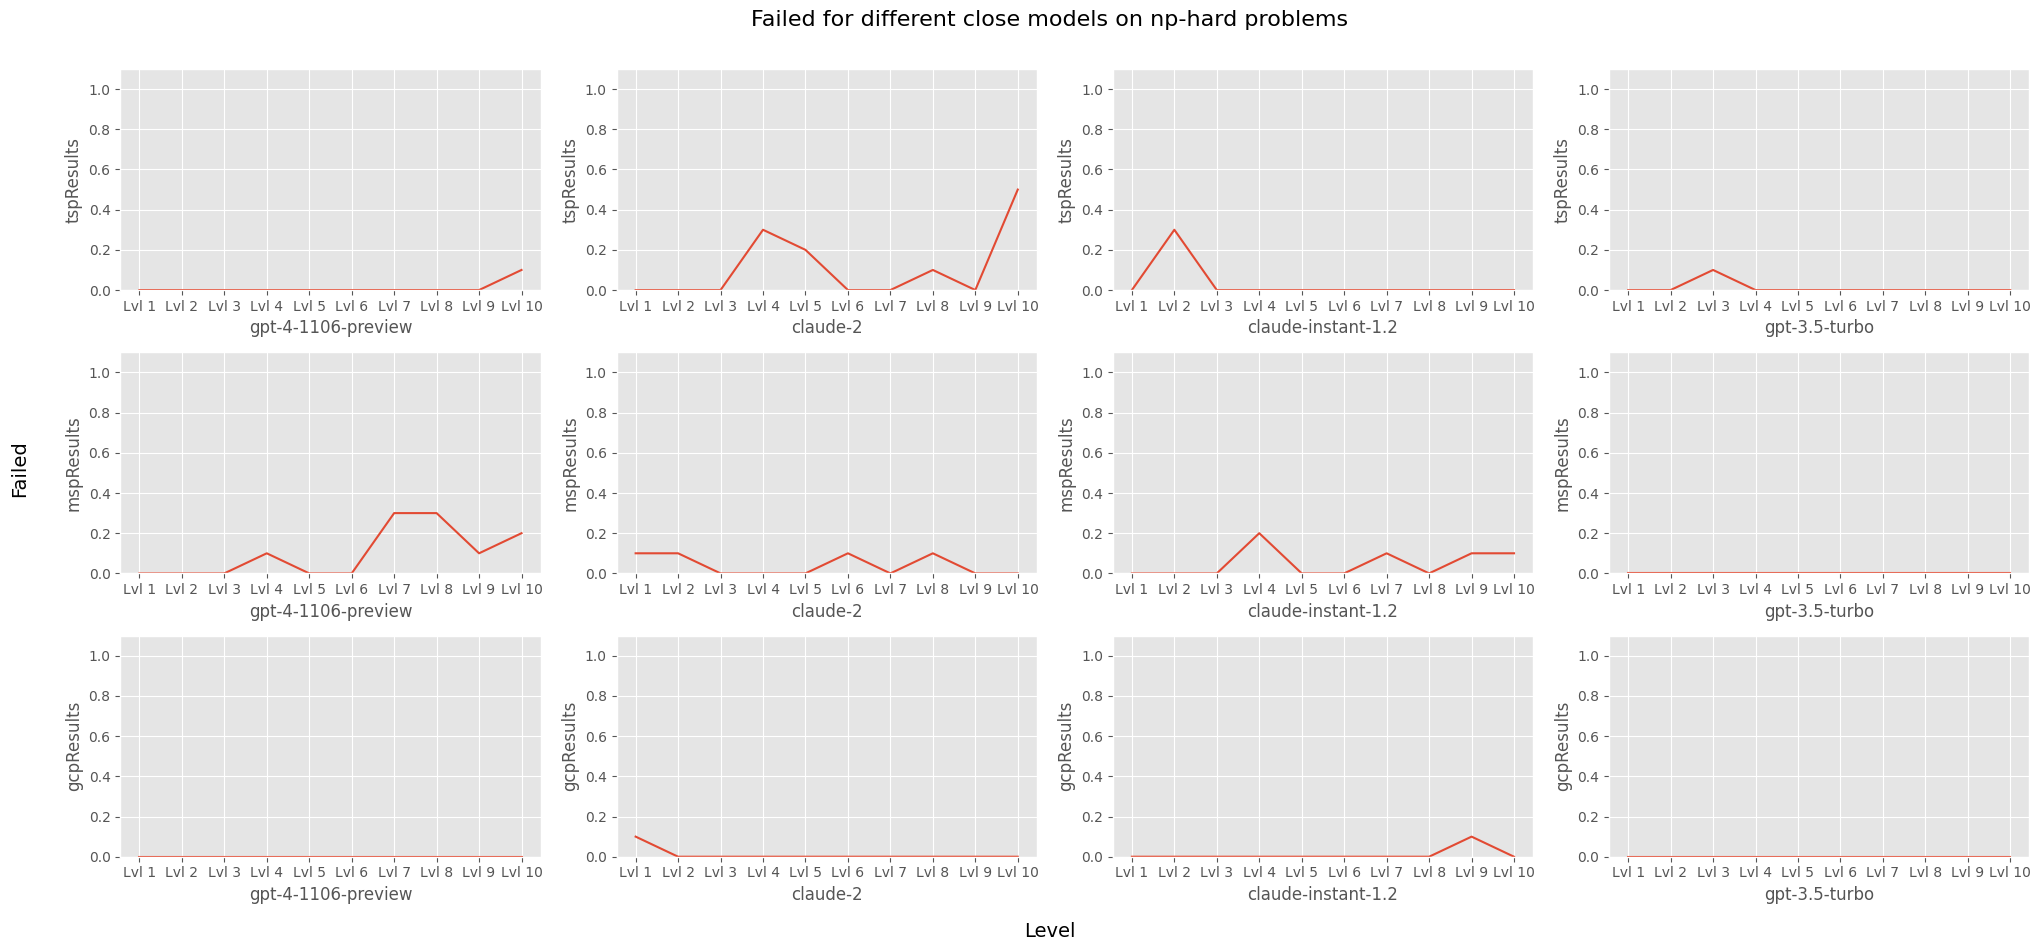

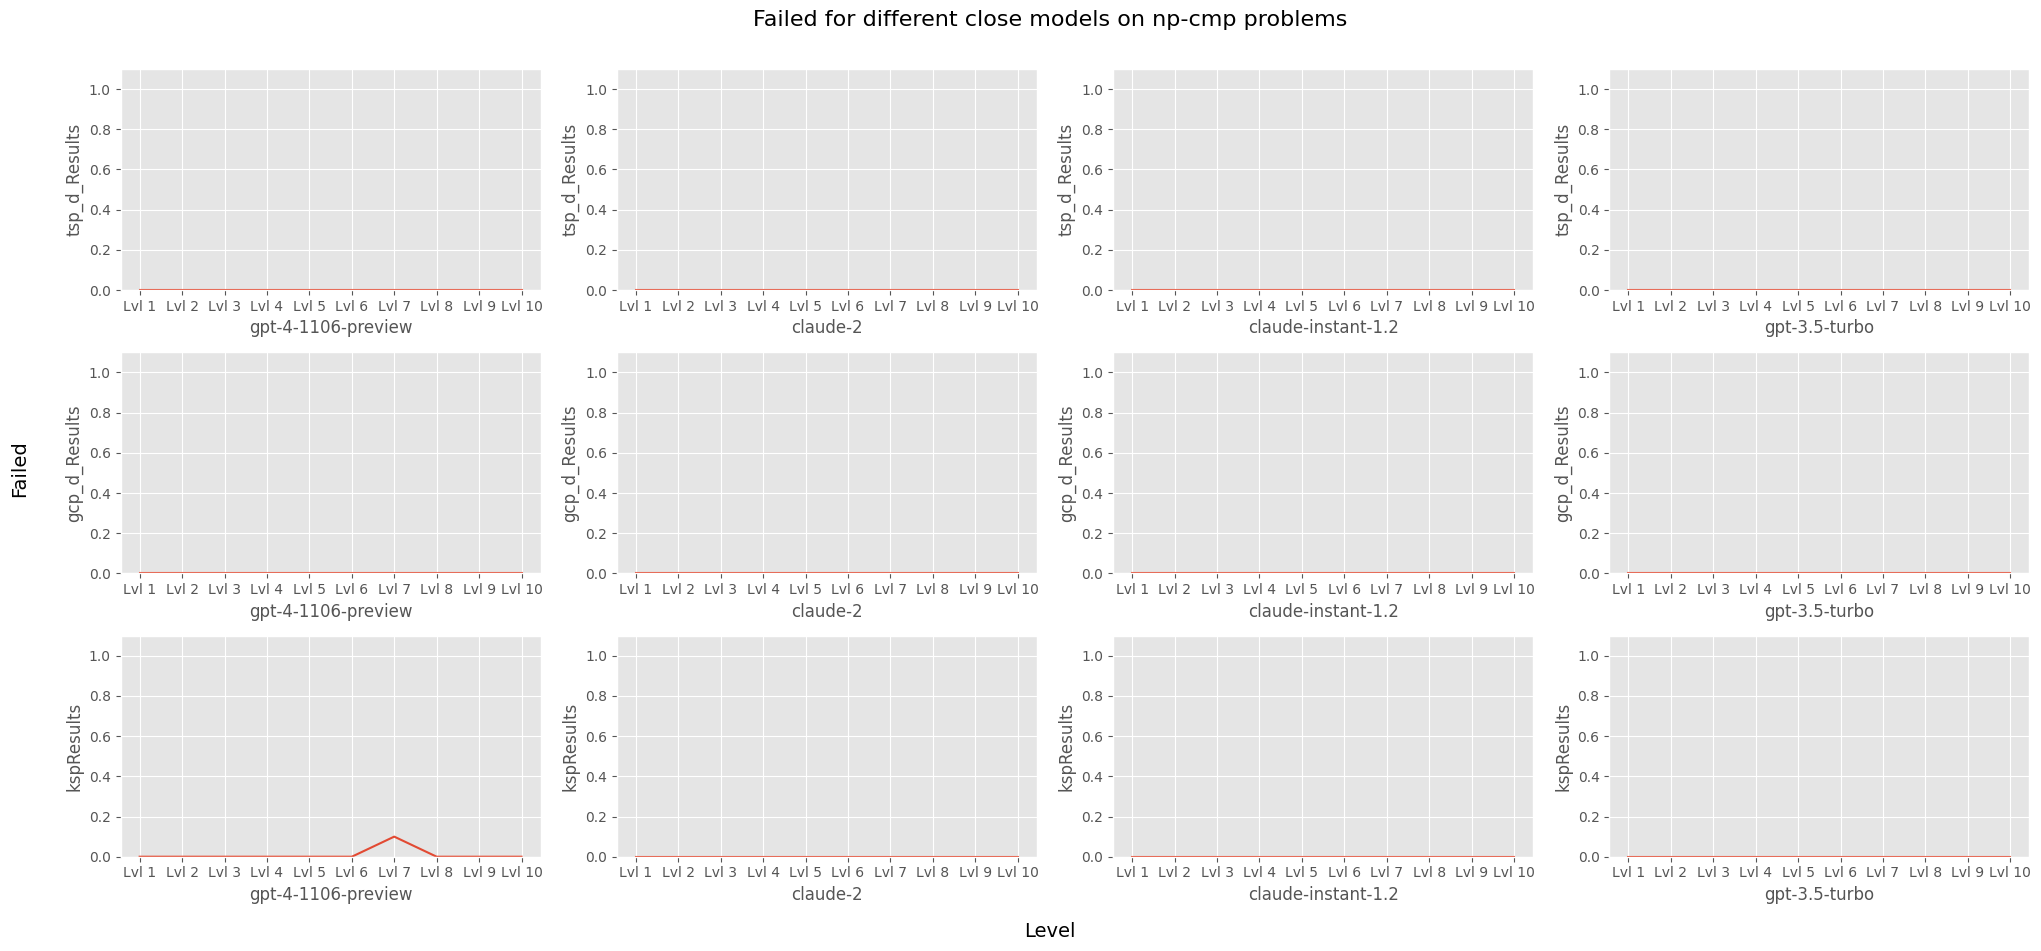

In [15]:
plot_figure('Failed', close_model_df, prefix='close')

#### Save to csv file

In [16]:
result_df.to_csv('results.csv', index=False)

In [17]:
# import altair as alt

# def plot_figure(y_name, result_df, prefix=''):
#     # Create a single chart for all models and problems
#     chart = alt.Chart(result_df).mark_line().encode(
#         x=alt.X('level:N', sort=[f'Lvl {i+1}' for i in range(10)]),
#         y=alt.Y(y_name, scale=alt.Scale(domain=(0, 1)), title='Accuracy'),
#         # color='model:N',
#         column=alt.Column('model:N', sort=close_models, title=None),
#         # row=alt.Row('problem:N', sort=alt.SortField('problem_order', order='ascending')),
#         color = alt.Color('problem:N', scale=alt.Scale(scheme='category20'), title='Problem'),
#         tooltip=['problem:N']
#     ).properties(
#         width=240,
#         height=180
#     ).resolve_scale(
#         x='independent',
#         y='independent'
#     )

#     chart.save(f'figures/{prefix}_accuracy.html')
#     return chart

# # Call the function with your DataFrame and y_name
# plot_figure('Average accuracy', close_model_df, 'close')